In [1]:
import os

import matplotlib.pyplot as plt
import random
from pennylane import numpy as np
from tqdm import tqdm
#from qbmqsp.qbm import QBM
from qbmqsp.utils import construct_multi_fcqbm_pauli_strings
from gen_data import xxz_gibbs_state, basis_encoding, gen_boltzmann_dist, gen_discrete_gauss_dist
from qbmqsp.src.utils import import_dataset, split_dataset_labels, split_data
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
import scipy.linalg as spl

import pennylane as qml
from pennylane import numpy as np
from pennylane.pauli.utils import string_to_pauli_word

from qbmqsp.hamiltonian import Hamiltonian
from qbmqsp.qsp_phase_engine import QSPPhaseEngine
from qbmqsp.qevt import QEVT
from qbmqsp.rel_ent import relative_entropy

import seaborn as sns
import numpy


import itertools

from functools import partial

In [2]:
def generate_pauli_strings_tfim(num_qubits,n_visible,restricted=False):
    """
    Generate Pauli strings for a transverse field Ising model as a 
    boltzmann machine .
    
    Parameters:
    num_qubits (int): Number of qubits in the quantum Boltzmann machine.
    n_visible (int): Number if visible units.
    restricted (bool) 
    
    Returns:
    list: List of Pauli strings representing the Hamiltonian.
    """
    pauli_strings = []

    # Local transverse field terms (X_i)
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        pauli_strings.append(''.join(pauli_string))

    # Interaction terms (Z_i Z_j)
    for i, j in itertools.combinations(range(num_qubits), 2):
        if restricted:
            if i<n_visible and j>=n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))
        else:
            if i<n_visible:
                
                pauli_string = ['I'] * num_qubits
                
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                   
                pauli_strings.append(''.join(pauli_string))       
    return pauli_strings

generate_pauli_strings_tfim(7,3,False)   

['ZIIIIII',
 'IZIIIII',
 'IIZIIII',
 'IIIZIII',
 'IIIIZII',
 'IIIIIZI',
 'IIIIIIZ',
 'ZZIIIII',
 'ZIZIIII',
 'ZIIZIII',
 'ZIIIZII',
 'ZIIIIZI',
 'ZIIIIIZ',
 'IZZIIII',
 'IZIZIII',
 'IZIIZII',
 'IZIIIZI',
 'IZIIIIZ',
 'IIZZIII',
 'IIZIZII',
 'IIZIIZI',
 'IIZIIIZ']

In [31]:
import seaborn as sns

def evaluate_qbm(qbm,testing_dataset,cluster,plot=False,quantile=0.95,method='min'):

    '''
    Evaluates the QBM pn the testing dataset.
    Parameters:
    qbm : QBM instance
    testing_dataset 
    cluster : The number of clusters in the dataset
    quantile
    method : When 'min' is used the energy of a given input vector is taken to be the minimum energy that total configuration achieves.
            In case of 'mean' the average value is used to assign it an energy.

    Returns:
    precision, recall, f1_score
    
    '''
    #training_data=numpy.expand_dims(training_data[:,0],axis=1)
    outliers = qbm.get_binary_outliers(
    dataset=testing_dataset, outlier_index=cluster)

    #outliers=numpy.expand_dims(outliers[:,0],axis=1)
    

    points = qbm.get_binary_cluster_points(
    dataset=testing_dataset, cluster_index=cluster-1)

    #points=numpy.expand_dims(points[:,0],axis=1)
    #print(points)
    predict_points_cluster = np.zeros(len(points), dtype=int)
    predict_points_outliers = np.zeros(len(outliers), dtype=int)
    qbm.calculate_outlier_threshold(quantile, method)
    print("Outlier threshold: ", qbm.outlier_threshold)
    print("Calculate outlier Energy")

    testing_data, testing_labels = split_dataset_labels(testing_dataset)
#testing_data=numpy.expand_dims(testing_data[:,0],axis=1)

    outlier_energy = []
    for index, outlier in enumerate(tqdm(outliers), 0):
        outlier = np.reshape(outlier, (qbm.dim_input))
        predict_points_outliers[index], this_outlier_energy = qbm.predict_point_as_outlier(
            outlier,method)
        outlier_energy.append(this_outlier_energy)
    outlier_energy = np.array(outlier_energy)

    o = outlier_energy.reshape((outlier_energy.shape[0]))

    print("Calculate cluster energy")
    cluster_point_energy = []

    for index, point in enumerate(tqdm(points), 0):
        point = np.reshape(point, (qbm.dim_input))
        predict_points_cluster[index], this_cluster_point_energy = qbm.predict_point_as_outlier(
        point,method)
        cluster_point_energy.append(this_cluster_point_energy)
    cluster_point_energy = np.array(cluster_point_energy)

    c = cluster_point_energy.reshape((cluster_point_energy.shape[0]))

    title='test'
#qbmqsp.src.utils.save_output(title="cluster_" + title, object=c)
#QBM.plot_energy_diff([o, c], qbm.outlier_threshold, title + ".pdf")

#QBM.plot_hist(c, o, qbm.outlier_threshold, "qbm_hist" + ".pdf")

########## OUTLIER CLASSIFICATION ##########
    print('Outlier classification: Results...')
    predict_points = np.concatenate(
        (predict_points_cluster, predict_points_outliers))

    print("Predicted points test: ", predict_points)

    true_points = np.concatenate(
        (np.zeros_like(cluster_point_energy), np.ones_like(outlier_energy)))

    accuracy, precision, recall = accuracy_score(true_points, predict_points), precision_score(
        true_points, predict_points), recall_score(true_points, predict_points)
    f1 = f1_score(true_points, predict_points)
    tn, fp, fn, tp = confusion_matrix(
        true_points, predict_points, labels=[0, 1]).ravel()

    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, \nNum True Negative: {tn}, Num False Negative: {fn}, Num True Positive: {tp}, Num False Positive: {fp}')

#print(f'Wallclock time: {(end-start):.2f} seconds')
    lab=cluster-1
    print("Outlier threshold: ", qbm.outlier_threshold)
    print("Average clusterpoint energy: ", np.average(cluster_point_energy))
    print("Outlier energy: ", outlier_energy)
    
    if plot==True:
        plt.figure()
        plt.title('Test Dataset')
        sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
        sns.scatterplot(x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab], c='r',palette='coolwarm')
        
    #plt.title('Predicted Points')
    #sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1], hue=predict_points,palette='coolwarm')
    return precision,recall,f1

class QBM():
    """Quantum Boltzmann machine (QBM) based on quantum signal processing.

    Parameters
    ----------
    β, enc:
        Same as attributes.
    h, θ:
        See qbmqsp.hamiltonian.Hamiltonian
    δ, polydeg:
        See qbmqsp.qsp_phase_engine.QSPPhaseEngine
    hnodes : Number of hidden nodes
    epochs: Number of epochs to train
    restricted (bool): [default] True
    
    
    Attributes
    ----------
    β : float
        Inverse temperature.
    enc : str in {'general', 'lcu'}
        Unitary block encoding scheme.
    H : qbmqsp.hamiltonian.Hamiltonian
        Constructed from parameters (h, θ).
    qsp : qbmqsp.qsp_phase_engine.QSPPhaseEngine
        Constructed from parameters (δ, polydeg).
    qevt : qbmqsp.qevt.QEVT
        Quantum eigenvalue transform to realize matrix function f(A) = exp(- τ * |A|). Updated after each training epoch.
    observables : qml.operation.Observable
        Observables w.r.t which the QBM is measured to optimize via gradient descent.
    aux_wire, enc_wires, sys_wires, env_wires : list[int]
        Quantum register wires of quantum circuit that prepares and measures the QBM.
    """
    
    
    
    
    
    def __init__(self,data,h: list[str], θ: np.ndarray[float], enc: str, δ: float, polydeg: int, β: float, hnodes,epochs=1,restricted=True) -> None:
        if β < 0:
            raise ValueError("__init__: β must not be negative.")
        
        self.epochs=epochs
        self.β = β
        self.enc = enc
        self.H = Hamiltonian(h, θ)
        self.qsp = QSPPhaseEngine(δ, polydeg)
        self.qevt = self._construct_qevt()
        self.aux_wire, self.enc_wires, self.sys_wires, self.env_wires = self._construct_wires()
        self.observables = self._construct_obervables()
        
        self.encoded_data, bits_input_vector, num_features = self.binary_encode_data(data, use_folding=True)
        self.dim_input = bits_input_vector * num_features
        self.quantile=0.95
        self.dim_input=n_visible
        self.n_hidden_nodes=hnodes
        
        self.qubits=self.dim_input+self.n_hidden_nodes
        
        self.restricted=restricted

        if self.restricted:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        else:
            
            self.weights_visible_to_visible,self.weights_visible_to_hidden=self.get_weights(self.H.θ)
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        

    def get_binary_cluster_points(self,dataset, cluster_index: int) -> np.ndarray:
        points = np.array([entry[:-1]
                           for entry in dataset if entry[-1] <= cluster_index])

        return self.binary_encode_data(points, use_folding=False)[0]
    
    def get_binary_outliers(self,dataset, outlier_index: int):
        outliers = np.array([entry[:-1]
                            for entry in dataset if entry[-1] >= outlier_index])

        return self.binary_encode_data(outliers, use_folding=False)[0]
  
    def binary_encode_data(self,data, use_folding=False):
        """ Encode a numpy array of form [[numpy.int64 numpy.int64] ...] into a
        list of form [[int, int, int, ...], ...].
        Example: encode [[107  73] [113  90] ...] to
        [[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0] .
        """

        # find out how many bits we need for each feature
        number_bits = len(np.binary_repr(np.amax(data)))
        number_features = data.shape[1]

        binary_encoded = ((data.reshape(-1, 1) & np.array(2 **
                          np.arange(number_bits-1, -1, -1))) != 0).astype(np.float32)
        if use_folding:
            return binary_encoded.reshape(len(data), number_features*number_bits), number_bits, number_features
        else:
            return binary_encoded.reshape(len(data), number_features, number_bits), number_bits, number_features
    
    
    def n_qubits(self, registers: str | set[str] = None) -> int:
        """Return number of qubits per registers.
        
        Parameters
        ----------
        registers : str | set[str]
            Quantum registers whose number of qubits should be returned.
            Must be an element from or a subset of {'aux', 'enc', 'sys', 'env'}.

        Returns
        -------
        n : int
            Number of qubits used per registers.
        """
        if registers is None:
            registers = {'aux', 'enc', 'sys', 'env'}
        elif type(registers) == str:
            registers = {registers}
        if not registers.issubset({'aux', 'enc', 'sys', 'env'}):
            raise ValueError("n_qubits: registers must be an element from or a subset of %r." % {'aux', 'enc', 'sys', 'env'})
        
        n = 0
        if 'env' in registers:
            n += self.qevt.n_qubits('sys')
        registers.discard('env')
        if len(registers) != 0:
            n += self.qevt.n_qubits(registers)
        return n

    def _generate_qsp_phases(self) -> np.ndarray[float]:
        τ = 2*self.β / (1-self.qsp.δ) * self.H.θ_norm()
        φ = self.qsp.generate(τ)
        return φ

    def _construct_qevt(self) -> QEVT:
        φ = self._generate_qsp_phases()
        h_δ, θ_δ = self.H.preprocessing(self.qsp.δ)
        return QEVT(h_δ, θ_δ, self.enc, φ)
    
    def _construct_wires(self) -> tuple[list[int], list[int], list[int], list[int]]:
        wires = list(range(self.n_qubits()))
        aux_wire = wires[: self.n_qubits('aux')]
        enc_wires = wires[self.n_qubits('aux') : self.n_qubits({'aux', 'enc'})]
        sys_wires = wires[self.n_qubits({'aux', 'enc'}) : self.n_qubits({'aux', 'enc', 'sys'})]
        env_wires = wires[self.n_qubits({'aux', 'enc', 'sys'}) : self.n_qubits({'aux', 'enc', 'sys', 'env'})]
        return aux_wire, enc_wires, sys_wires, env_wires

    def _construct_obervables(self) -> list[qml.operation.Observable]:
        n_aux_enc = self.n_qubits({'aux', 'enc'})
        aux_enc_wires = self.aux_wire + self.enc_wires
        proj0 = qml.Projector( [0] * n_aux_enc, aux_enc_wires)

        new_sys_wires = list(range(self.n_qubits('sys')))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        observables = [proj0] + [proj0 @ string_to_pauli_word(self.H.h[i], wire_map) for i in range(self.H.n_params)]
        return observables
    
    def _bell_circuit(self) -> None:
        for i, j in zip(self.sys_wires, self.env_wires):
            qml.Hadamard(i)
            qml.CNOT([i, j])

    def probabilistic(self):
        
        bit_strings=[]
        for i in range(2**(self.n_hidden_nodes+self.dim_input)):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes+self.dim_input)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            
      
        sample = random.choices(bit_strings, k=1)

        for i,x in enumerate(sample[0]):
            if x==1:
                qml.PauliX(wires=[self.sys_wires[i]])
    
    def _prepare(self) -> None:
        self._bell_circuit()
        #self.probabilistic()
        self.qevt.circuit(self.aux_wire, self.enc_wires, self.sys_wires)
    
    def _measure(self) -> None:
        #return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        
        return [qml.expval(self.observables[i]) for i in range(len(self.observables))]
    
    
    def get_sample(self,shots=1):
        dev = qml.device(dev_name,shots=shots, wires=self.n_qubits({'aux','enc','sys'}))
        @qml.qnode(dev)
        
        def quantum_circuit():
            
            self._prepare()
            return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        
        sample=quantum_circuit()
        return sample
    
    def get_average_configuration_from_samples(self, samples: list, input_vector=None):
        ''' Takes samples from Annealer and averages for each neuron and connection
        '''

        # unclamped if input_vector == None
        unclamped = input_vector== None

        # biases (row = sample, column = neuron)
        np_samples = np.vstack(
            tuple([np.array(list(sample.values())) for sample in samples]))
        avgs_biases = np.average(np_samples, axis=0)
        avgs_biases_hidden = avgs_biases[self.dim_input:] if unclamped else avgs_biases
        avgs_biases_visible = avgs_biases[:
                                          self.dim_input] if unclamped else input_vector

        # weights
        avgs_weights_visible_to_hidden = np.zeros(
            self.weights_visible_to_hidden.shape)
        if not self.restricted:
            avgs_weights_visible_to_visible = np.zeros(
                self.weights_visible_to_visible.shape)
        for v in range(self.dim_input):
            # visible to hidden connections
            for h in range(self.n_hidden_nodes):
                x, y = (np_samples[:, v], self.dim_input +
                        h) if unclamped else (input_vector[v], h)
                avgs_weights_visible_to_hidden[v, h] = np.average(
                    x*np_samples[:, y])
            # visible to visible connections
            if not self.restricted:
                for v2 in range(v, self.dim_input):
                    x, y = (np_samples[:, v], np_samples[:, v2]) if unclamped else (
                        input_vector[v], input_vector[v2])
                    avgs_weights_visible_to_visible[v, v2] = np.average(x*y)

        if self.restricted:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, None
        else:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, avgs_weights_visible_to_visible

    def _compute_expvals(self) -> np.ndarray[float]:
        dev = qml.device(dev_name,wires=self.n_qubits({'aux','enc','sys','env'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
        @qml.qnode(dev)
        
        def quantum_circuit():
            self._prepare()
            if dev_name=='default.qubit':
                return self._measure()
            else:
                observation_wires=[[]]
                
                for term in self.H.h:
                    list=[]
                    for i,el in enumerate(term):
                        if el!='I':
                            list.append(i+self.n_qubits({'aux','enc'}))
                    observation_wires.append(list)
                
                probabilities=[ qml.probs(wires=[0,1]+wires) for wires in observation_wires]

                
                return probabilities
                
            
        
        if dev_name=='default.qubit':
        
            measurements = quantum_circuit()
            
            success_probability = measurements[0]
           
            
            qbm_expvals = measurements[1:] / success_probability
            
            return self.β*self.H.θ_norm()*(1+self.qsp.δ)/(1-self.qsp.δ)*qbm_expvals
        
        else:

            probabilities=quantum_circuit()
            success_probability=probabilities[0][0]
            print(success_probability)
            rest_probabilites=probabilities[1:]
            exp_val=[]
            for i,term in enumerate(rest_probabilites):
                if i<self.n_hidden_nodes+self.dim_input:
                
                    ps=np.reshape(term,(4,2))[0]
                
                    exp_val.append(ps[0]-ps[1])
                else:
                
                    ps=np.reshape(term,(4,4))[0]
        
                    exp_val.append(ps[0]-ps[1]-ps[2]+ps[3])      
            
        
        
       
            return self.β*self.H.θ_norm()*(1+self.qsp.δ)/(1-self.qsp.δ)*np.array(exp_val)/success_probability
    
    def _loss_func(self, ρ0: np.ndarray[float], ρ1: np.ndarray[float]) -> float:
        return relative_entropy(ρ0, ρ1, check_state=True).item()
    
    def assemble(self) -> np.ndarray[float]:
        """Assemble QBM."""
        expH = spl.expm(-self.β * self.H.assemble())
        return expH / np.trace(expH)
    
    
    def get_energy(self,input_vector,k=30,method='min'):
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        print(new_biases)
        
    # List to store all bit strings
        bit_strings=[]
        p=[]
    # There are 2^n bit strings of length n
        #print(new_biases)
        for i in range(2**self.n_hidden_nodes):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes)
             
            bit_list = np.array([1-2*int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            print(bit_list)
            p.append(np.exp(-self.β*np.dot(bit_list,new_biases)))

        p=np.array(p)
        print(p)
        probabilities=p/np.sum(p)
        
        print(probabilities)
        sample = random.choices(bit_strings, weights=probabilities, k=k)
        energies=np.dot(sample,new_biases)
        
        if method=='min':
            return np.min(energies)    
        else:
            
             
            avg_energy=np.sum(probabilities*np.dot(np.array(bit_strings),new_biases))
            return avg_energy
           
            

               

            
     
    
    def free_energy(self,method='min',input_vector=None):
        '''Function to compute the free energy'''

        # calculate hidden term
        
         
        if self.n_hidden_nodes==0: 
            hidden_term=0
        else:
            hidden_term = self.get_energy(method=method,input_vector=input_vector)

        # calculate visible_term
        # visible bias
        visible_term = np.dot(
            1-2*np.array(input_vector), self.H.θ[:self.dim_input]) #/beta
        
        pos_neg=1-2*input_vector
        if self.restricted==False:
             
             
             vv_interaction=np.matmul(self.weights_visible_to_visible,pos_neg)
             vv_interaction=np.matmul(pos_neg.T,vv_interaction)
             visible_term=visible_term+vv_interaction
        

        return hidden_term + visible_term
    
    def calculate_outlier_threshold(self, quantile=0.95,method='min'):
        
        self.quantile = quantile
        energy_func=partial(self.free_energy,method)
        
        energies = np.apply_along_axis(
            energy_func, axis=1, arr=self.encoded_data)
        
        self.outlier_threshold = np.quantile(energies, self.quantile)
        
        
    
    
    
    
    def get_average_configurations(self,input_vector=None):
        '''
        Function for giving averge configurations of all qubits for the gibbs state of the system.
        
        If input vector is clamped at a certain value , it gives configuration of hidden units only.
       
    
        Parameters:
        input vector (np.ndarray)
        
    
        Returns:
        list: List of expectation values of hamilatonian terms.
        '''
        
        
        # unclamped values
        if input_vector is None:
            
            qbm_expvals=self._compute_expvals()
            
            return qbm_expvals
        
        # clamped values
        
        
        if self.restricted:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        else:
            
            self.weights_visible_to_visible,self.weights_visible_to_hidden=self.get_weights(self.H.θ)
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        #np.matmul(input_vector, self.weights_visible_to_hidden).flatten()
        
        Q_new=new_biases

        exp_vals=-np.tanh(self.β*new_biases)
        return exp_vals
            
       
        
        
    def train_for_one_iteration(self, batch, learning_rate):

        '''
        Performs the update for one batch in the dataset.

        Parameters:

        batch 
        learning_rate
       
        Returns:
        list: List of avg errors in the visible configuration for each element of the batch.
        '''
        
        
        errors = 0
        #errors_biases_visible = 0
        #errors_weights_visible_to_hidden = 0
        #if not self.restricted:
          #  errors_weights_visible_to_visible = 0

        for i,input_vector in enumerate(batch):
            
            
            if i==0:
                unclamped_config = self.get_average_configurations() 
                print(unclamped_config)
            
            clamped_config = self.get_average_configurations(input_vector) # has only expectations over hidden units
            
            # avgs_weights_visible_to_visible_clamped only has a value if not restricted
            #print(clamped_config)
            
            # Getting averages for all qubits , avg_visible=input_vector
        
            
            
            full_clamped_config=np.zeros_like(unclamped_config)
            
            full_clamped_config[:self.dim_input]=1+(-2)*input_vector   
            full_clamped_config[self.dim_input:self.dim_input+self.n_hidden_nodes]=clamped_config
            
            pos_neg=1-2*input_vector
            if self.restricted:
                
                
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.kron(pos_neg,clamped_config)
            
            else:
                
                
                
                visible=list(pos_neg[j]*pos_neg[i] for j in range(len(pos_neg)) for i in range(j+1,len(pos_neg)))
                hidden=np.kron(pos_neg,clamped_config)
                for i in range(1,self.dim_input+1):
                    for j in range(self.n_hidden_nodes):
                        visible.insert((i-1)*self.n_hidden_nodes+(i)*(self.dim_input-1)-(i-1)+j,hidden[self.n_hidden_nodes*(i-1)+j])
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.array(visible)
            
            
            errors += full_clamped_config - unclamped_config
            
            
            print(errors)
            
           
            
            

        errors /= batch.shape[0]

        print('final_error', errors)
        
        self.H.θ = self.H.θ - learning_rate * errors
                
        self.qevt = self._construct_qevt()
                
       
        
        
        return np.average(errors[:self.dim_input]**2)
    
    
    
    
    def train_model(self, batch_size=8, learning_rate=0.005,save=False):
        
        data = self.encoded_data
        
        weights=[]
        batch_num = data.shape[0] // batch_size
        diff = data.shape[0] % batch_size
        qbm.batch_size=batch_size
        if diff:
            
        
            data = data[:-diff]
            last_batch = data[data.shape[0] - diff:]
        
        
        
        batches = np.vsplit(data, batch_num)
        
        if diff:
            batches.append(last_batch)
              
        losses=[]
        
        for epoch in range(1, self.epochs+1):
            print(f'Epoch {epoch}')
            batch_errors = None
            batchnum = 1
            errors_epoch=[]
            for batch in tqdm(batches):
                    #print(batch)
                    errors = self.train_for_one_iteration(batch, learning_rate)
                    
                    if type(batch_errors) is np.ndarray:
                        batch_errors = np.hstack((batch_errors, errors))
                    else:
                        batch_errors = errors
                    #self.save_weights(
                        #f'e{epoch}_b{batchnum}_{self.paramstring}')
                    batchnum += 1
               
                    #self.save_weights(
                     #   f'e{epoch}_b{batchnum}_{self.paramstring}')
                    #raise e
                    errors_epoch.append(errors)
            
            losses.append(errors_epoch)
            weights.append(self.H.θ)
            if save==True:
                try:
                    np.savez(f'./epoch{epoch}_weights_h{self.n_hidden_nodes}_v{self.dim_input}_lr{self.learning_rate}_e{self.epochs}',self.H.θ)
                    np.savez(f'./epoch{epoch}_losses_h{self.n_hidden_nodes}_v{self.dim_input}_lr{self.learning_rate}_e{self.epochs}',errors_epoch)
                except:
                    print('error_saving')
        self.calculate_outlier_threshold(self.quantile)
        
        
        
        return losses, weights 
    
    #self.error_container.add_error(batch_errors)
        #self.error_container.plot("qbm_errors" + self.paramstring)
        #self.save_weights(title="final_weights_qbm" + self.paramstring)
        # make list of values of the error dicts
        
        #self.calculate_outlier_threshold(self.quantile)
       
    def predict_point_as_outlier(self, input,method):
        energy = self.free_energy(method,input)
        if energy >= self.outlier_threshold:
            return 1, energy
        return 0, energy
        
    
    def get_weights(self,Q):
        weights_vh_vv=list(Q[self.dim_input+self.n_hidden_nodes:])
            
        for i in range(1,self.dim_input+1):
            for j in range(i):
                weights_vh_vv.insert((self.dim_input+self.n_hidden_nodes)*(i-1)+j,0)
            
        weights_vh_vv=np.array(weights_vh_vv)
        weights_visible_to_visible=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,0:self.dim_input]
        weights_visible_to_hidden=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,self.dim_input:]
    
        return weights_visible_to_visible,weights_visible_to_hidden
    
    def save_model(path,dataset_name):
         path=Path(path/dataset)
         path.mkdir(exist_ok=True)
         np.savez(f'_e{qbm.epochs}_h{qbm.n_hidden_nodes}_v{qbm.dim_input}_b{qbm.batch_size}',qbm.H.θ)
        
     
    

    

C:\Users\ge84gac\AppData\Local\Temp\ipykernel_19512\637539819.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


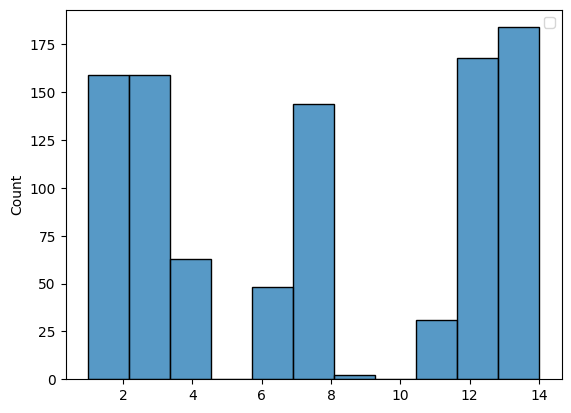

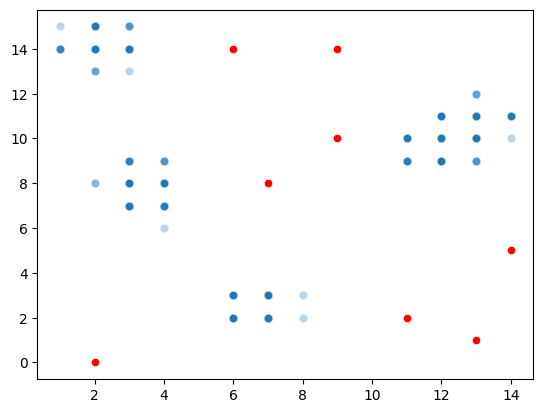

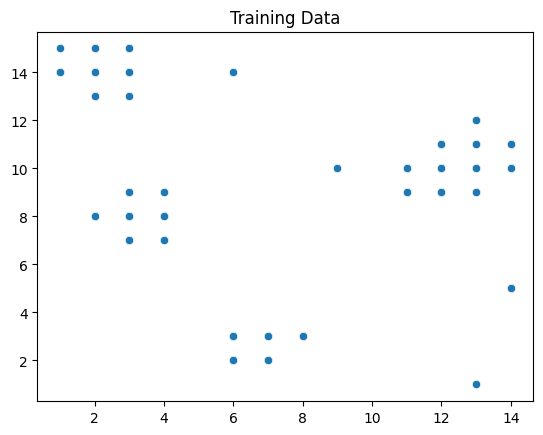

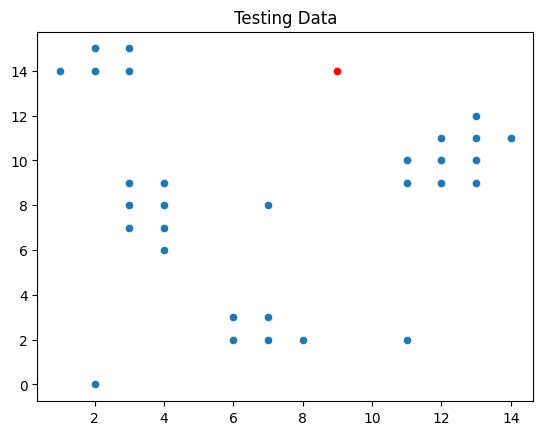

<Figure size 640x480 with 0 Axes>

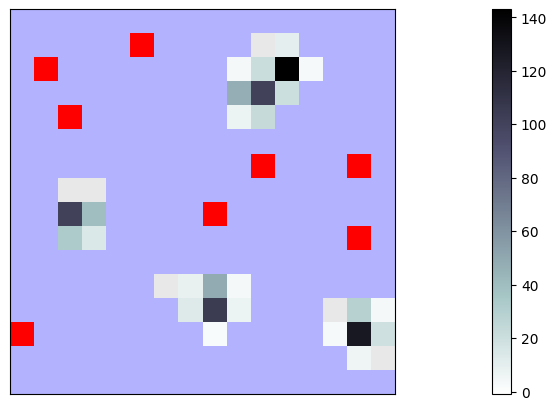

In [29]:




CLUSTER=5

PATH= '../../datasets/good_datasets/l_o8_c5_d2_v0.35_p190_4.npy'
data = import_dataset(PATH)


#data[data[:,2]==11]=[6,14,11]



training_dataset, testing_dataset = split_data(data, CLUSTER)

training_data, training_labels = split_dataset_labels(training_dataset)
testing_data,testing_labels=split_dataset_labels(testing_dataset)

sns.histplot(data[:,0])
#sns.kdeplot(testing_data[:,1],label='y')
plt.legend()
plt.figure()
#training_labels
lab=CLUSTER-1

sns.scatterplot(x=data[:,0],y=data[:,1], alpha=0.3)
sns.scatterplot(c='r',x=data[data[:,2]>lab][:,0],y=data[data[:,2]>lab][:,1])


plt.figure()

lab=8
plt.title('Training Data')
sns.scatterplot(x=training_data[:,0],y=training_data[:,1])
sns.scatterplot(c='r',x=training_data[:,0][training_labels==lab],y=training_data[:,1][training_labels==lab])
plt.figure()


plt.title('Testing Data')
sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
sns.scatterplot(c='r',x=testing_data[:,0][testing_labels==lab],y=testing_data[:,1][testing_labels==lab])

plt.figure()




#data = import_dataset(PATH)

training_dataset, testing_dataset = split_data(data, CLUSTER)

training_data, training_labels = split_dataset_labels(training_dataset)
testing_data,testing_labels=split_dataset_labels(testing_dataset)



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the known array for the x-axis values





x_values = np.arange(0,16,1)
y_values=np.arange(0,16,1)

c_values=[]
for x in x_values:
    row_values=[]
    for y in y_values:
        num=len(data[(data[:,1]==y) & (data[:,0]==x)] )
        
        if num==1:
            if data[(data[:,1]==y) & (data[:,0]==x)][0][2]>=CLUSTER:
            
                row_values.append(-1)
            else:
                row_values.append(1)
        else:
            row_values.append(num)
    c_values.append(row_values)

#c_values=np.array(c_values)/np.max(c_values)


# Ensure the x_values array has the same length as the number of columns


cols = len(x_values)
rows = len(y_values)
# Number of rows in the grid

# Repeat the x_values array to create a 2D array for the grid

values=np.array(c_values)
# Normalize the values to [0, 1] for color mapping

norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())

# Create a colormap
cmap = plt.get_cmap('bone_r')


# Create the grid

fig, ax = plt.subplots(figsize=(25,5))

# Plot each cell with a color corresponding to the value
for i in range(rows):
    for j in range(cols):
        if values[i][j]==0:
            color=(0.0,0.0,1.0,0.3)
        elif values[i][j]==1:
            color=(0.0,0.0,0.0,0.09)
        elif values[i][j]==-1:
            color=(1.0,0.0,0.0,1.0)
        else:
            color = cmap(norm(values[i, j]))
        rect = plt.Rectangle((j, i), 1, 1, facecolor=color)
        ax.add_patch(rect)

# Set the limits and aspect ratio
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_aspect('equal')

# Remove the axes for better visualization


ax.set_xticks([])
ax.set_xticklabels([],rotation=90)
ax.set_yticks([])  # Remove y-axis labels

# Show the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=ax)

# Display the plot
plt.show()


In [32]:


np.random.seed(seed=1)
random.seed(1)
#dev_name='qiskit.ibmq'

training_dataset, testing_dataset = split_data(data, CLUSTER)
training_data, training_labels = split_dataset_labels(training_dataset)
testing_data,testing_labels=split_dataset_labels(testing_dataset)

import numpy
#training_data=numpy.expand_dims(training_data[:,0],axis=1)
#training_data=training_data[0::]
n_hidden_units=1
n_visible=8
n_qubits = n_visible+n_hidden_units

restricted=False
h = generate_pauli_strings_tfim(n_qubits,n_visible,restricted)
print('Hamiltonian : ')
print(h)
nparams = len(h)

θ_init =np.random.rand(nparams)/nparams#np.loadtxt('./weights_7_3_un.txt')
enc = 'general'
δ = 0.3
polydeg = 80
β = 1.0
learning_rate = 0.1
epochs = 2

batch_size=30
dev_name='default.qubit'
#dev_name='lightning.qubit'

qbm = QBM(training_data,h, θ_init, enc, δ, polydeg, β,n_hidden_units,epochs,restricted)

errors,weights=qbm.train_model(batch_size,learning_rate)


Hamiltonian : 
['ZIIIIIIII', 'IZIIIIIII', 'IIZIIIIII', 'IIIZIIIII', 'IIIIZIIII', 'IIIIIZIII', 'IIIIIIZII', 'IIIIIIIZI', 'IIIIIIIIZ', 'ZZIIIIIII', 'ZIZIIIIII', 'ZIIZIIIII', 'ZIIIZIIII', 'ZIIIIZIII', 'ZIIIIIZII', 'ZIIIIIIZI', 'ZIIIIIIIZ', 'IZZIIIIII', 'IZIZIIIII', 'IZIIZIIII', 'IZIIIZIII', 'IZIIIIZII', 'IZIIIIIZI', 'IZIIIIIIZ', 'IIZZIIIII', 'IIZIZIIII', 'IIZIIZIII', 'IIZIIIZII', 'IIZIIIIZI', 'IIZIIIIIZ', 'IIIZZIIII', 'IIIZIZIII', 'IIIZIIZII', 'IIIZIIIZI', 'IIIZIIIIZ', 'IIIIZZIII', 'IIIIZIZII', 'IIIIZIIZI', 'IIIIZIIIZ', 'IIIIIZZII', 'IIIIIZIZI', 'IIIIIZIIZ', 'IIIIIIZZI', 'IIIIIIZIZ', 'IIIIIIIZZ']

Starting MATLAB engine.. Done.

Epoch 1


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

[-0.03377906 -0.01280683 -0.00054863 -0.00657954 -0.00544615 -0.02811402
 -0.01610063  0.0009578  -0.02517981 -0.01346137 -0.00508813 -0.02377625
 -0.02018827 -0.00673271  0.00146968 -0.02430617 -0.01038552 -0.02403431
 -0.01696754 -0.00116607 -0.01010714 -0.03031542 -0.00530134 -0.00402494
 -0.00494049 -0.00211222 -0.0209255  -0.03170132 -0.00033431 -0.0144776
 -0.00022967 -0.01954597 -0.01948073 -0.01119608 -0.00727222 -0.00922671
 -0.03082691 -0.01347011 -0.02325085 -0.01621817 -0.01521817 -0.01377275
 -0.0020903  -0.03117437 -0.00314976]
[ 1.03377906  1.01280683 -0.99945137  1.00657954 -0.99455385 -0.97188598
 -0.98389937 -1.0009578   0.05041152  1.01346137 -0.99491187  1.02377625
 -0.97981173 -0.99326729 -1.00146968 -0.97569383  0.03561722 -0.97596569
  1.01696754 -0.99883393 -0.98989286 -0.96968458 -0.99469866  0.02925664
 -0.99505951  1.00211222  1.0209255   1.03170132  1.00033431 -0.9855224
 -0.02500204 -0.98045403 -0.98051927 -0.98880392  1.00727222  1.00922671
  1.03082691  0

  6%|█████▏                                                                             | 1/16 [00:23<05:53, 23.59s/it]

[ 0.19389993  0.02071749 -0.23316526 -0.00433685 -0.11573876  0.03604506
 -0.23252485  0.09323336 -0.03900792  0.11283616 -0.28569361  0.0125351
 -0.02366669 -0.07308418 -0.13862246  0.10073649 -0.01567413 -0.2281139
 -0.03306539 -0.13764178 -0.22849239 -0.04417563  0.09902425  0.00100691
  0.00403301  0.0153077   0.01715597  0.15045106 -0.12910651 -0.07193332
  0.01156988 -0.15263742 -0.10955579  0.06870292 -0.01145359 -0.05410744
 -0.15716216 -0.03819038  0.03477497  0.03020858 -0.00102686 -0.03305448
 -0.03840021 -0.06813734 -0.01043382]
[-1.19389993 -1.02071749  1.23316526 -0.99566315 -0.88426124  0.96395494
 -0.76747515 -1.09323336  0.02459713  0.88716384 -0.71430639  0.9874649
  1.02366669 -0.92691582  1.13862246  0.89926351  0.03008492 -0.7718861
  1.03306539  1.13764178 -0.77150761  1.04417563  0.90097575  0.01340388
 -1.00403301 -1.0153077   0.98284403 -1.15045106 -0.87089349  1.07193332
 -0.02598067 -0.84736258  1.10955579  0.93129708 -0.98854641  1.05410744
  1.15716216  0.0

 12%|██████████▍                                                                        | 2/16 [00:46<05:24, 23.20s/it]

[ 0.5871356   0.419515   -0.70148578  0.07070049 -0.60021944 -0.07456332
 -0.53750429  0.55441848 -0.04274779  0.68389466 -0.91697135  0.18992835
 -0.27644167 -0.52037344 -0.29166774  0.64797261  0.00423384 -0.83672348
  0.11168338 -0.58359977 -0.69112798 -0.09279083  0.55477066  0.00212774
 -0.11138239  0.33957208  0.36443707  0.29976233 -0.67633578 -0.13599598
 -0.0417603  -0.44128923 -0.25216807  0.26528158  0.02686598  0.20667784
 -0.20344827 -0.23341933  0.10269693  0.06847899 -0.42879874 -0.03445096
 -0.1658688  -0.09015539  0.00600689]
[-1.5871356  -1.419515    1.70148578 -1.07070049 -0.39978056  1.07456332
 -0.46249571 -1.55441848  0.00293394  0.31610534 -0.08302865  0.81007165
  1.27644167 -0.47962656  1.29166774  0.35202739  0.03558002 -0.16327652
  0.88831662  1.58359977 -0.30887202  1.09279083  0.44522934  0.03768612
 -0.88861761 -1.33957208  0.63556293 -1.29976233 -0.32366422  1.13599598
  0.00194644 -0.55871077  1.25216807  0.73471842 -1.02686598  0.79332216
  1.20344827 

 19%|███████████████▌                                                                   | 3/16 [01:09<04:59, 23.00s/it]

[-0.26900315 -0.61259602  0.30002524 -0.25005689 -0.66254659  0.84090581
 -0.43437393  0.13193463  0.00751795  0.44861792 -0.7107914  -0.11278892
  0.40960552 -0.21929389  0.43260993  0.33201501 -0.03382254 -0.68237498
 -0.17754916  0.20524426 -0.58013574  0.5790633  -0.00339834  0.00278838
  0.28013316 -0.46480207  0.18456357 -0.41479914 -0.2111087   0.01441898
  0.01628978 -0.30309425 -0.04237444  0.0715762  -0.38173808 -0.25090371
 -0.03244352  0.12827817 -0.07945578 -0.13634371  0.05429416  0.05076419
  0.09526735 -0.02447722 -0.03770064]
[ 1.26900315 -0.38740398 -1.30002524  1.25005689 -0.33745341 -1.84090581
 -0.56562607  0.86806537 -0.07928231 -1.44861792 -0.2892086   1.11278892
 -1.40960552 -0.78070611 -1.43260993  0.66798499 -0.03794182  1.68237498
 -0.82245084  0.79475574  1.58013574  0.4209367  -0.99660166  0.06897598
 -1.28013316  1.46480207  0.81543643  1.41479914 -0.7888913  -1.01441898
  0.05547458 -0.69690575 -0.95762556  0.9284238   1.38173808  1.25090371
 -0.96755648 

 25%|████████████████████▊                                                              | 4/16 [01:32<04:37, 23.14s/it]

[ 0.19241136 -0.19943147 -0.08714302 -0.19649325 -0.49030601  0.60263464
 -0.24149499  0.34118642 -0.02334707  0.25914163 -0.65789263 -0.1563185
  0.06100227  0.00396206  0.28038551  0.34388445 -0.02403843 -0.42039048
 -0.26550013 -0.14648502 -0.33333736  0.41393528 -0.00251708  0.02227486
  0.25993169 -0.19350074  0.0082764  -0.22759757 -0.24238061  0.08046968
  0.02351358 -0.22817917 -0.11641076  0.07994061 -0.29534797  0.00191484
 -0.31832944 -0.03276868 -0.10560181  0.16802878  0.1781301  -0.01220002
  0.04234559  0.00673126 -0.02781011]
[ 0.80758864 -0.80056853 -0.91285698 -0.80350675  1.49030601  0.39736536
 -0.75850501  0.65881358  0.02793655 -1.25914163 -0.34210737 -0.8436815
  0.93899773  0.99603794 -1.28038551  0.65611555  0.02862791  1.42039048
  1.26550013 -0.85351498 -0.66666264  0.58606472 -0.99748292 -0.02686434
  0.74006831 -0.80649926 -1.0082764   1.22759757 -0.75761939 -1.08046968
 -0.02810305 -0.77182083  1.11641076 -1.07994061  1.29534797 -1.00191484
  1.31832944  0

 31%|█████████████████████████▉                                                         | 5/16 [01:54<04:10, 22.73s/it]

[ 0.23533201 -0.3128485  -0.1993409  -0.32643962 -0.41155904  0.46507469
 -0.67817281  0.29167403  0.01388877  0.40894608 -0.94875221 -0.13791271
  0.27837857 -0.28757996 -0.04331198  0.40720004  0.01507267 -0.48446014
  0.15797205 -0.14789574 -0.74089609  0.40179842  0.1038122   0.0111786
  0.19378146 -0.33186609  0.27351064  0.07704937 -0.36244139 -0.11868085
 -0.04423887 -0.38395492  0.15388366  0.09615797 -0.07481973  0.12862994
 -0.17948932  0.00742445 -0.23278132 -0.00682678 -0.08612579 -0.03598145
 -0.04801656 -0.00466284  0.01690187]
[-1.23533201 -0.6871515   1.1993409  -0.67356038 -0.58844096  0.53492531
 -0.32182719  0.70832597  0.01539362  0.59105392 -0.05124779  1.13791271
  0.72162143 -0.71242004  1.04331198 -1.40720004 -0.04435506 -0.51553986
  0.84202795  1.14789574 -0.25910391  0.59820158 -1.1038122  -0.04046099
 -1.19378146 -0.66813391  0.72648936 -1.07704937  1.36244139  1.11868085
  0.07352126 -0.61604508  0.84611634 -1.09615797 -0.92518027  0.87137006
 -0.82051068 -

 38%|███████████████████████████████▏                                                   | 6/16 [02:16<03:44, 22.47s/it]

[ 2.02381059e-01 -3.14806688e-01 -2.34183040e-01 -2.51636431e-01
 -4.41965403e-01  6.19545593e-01 -5.28483523e-01  2.74369524e-01
  2.69928324e-02  3.11820600e-01 -8.03287133e-01 -1.03927023e-01
  2.84938892e-01 -6.48868116e-02  8.94962035e-02  3.77594117e-01
 -9.00082840e-03 -3.66958935e-01  9.21715961e-02 -1.61172626e-01
 -5.73869670e-01  4.61180932e-01  1.56378252e-01  3.87039416e-03
  1.74596791e-01 -2.84205051e-01  2.21493823e-02  1.79741529e-02
 -3.30753631e-01 -8.48222652e-02 -1.38769927e-05 -4.21812772e-01
  1.58572077e-02  3.96263247e-02 -1.45743623e-01  4.33434978e-02
 -1.49767585e-01 -9.83829877e-03 -2.48676079e-01  6.53091512e-02
  4.75809125e-02 -4.78347373e-03  2.76837335e-02 -1.90660544e-03
  8.05743323e-03]
[-1.20238106 -0.68519331  1.23418304 -0.74836357  1.4419654   0.38045441
  1.52848352 -1.27436952 -0.07246813  0.6881794  -0.19671287  1.10392702
 -1.28493889 -0.93511319 -1.0894962   0.62240588  0.05447613 -0.63304106
  0.9078284  -0.83882737 -0.42613033 -1.46118093

 44%|████████████████████████████████████▎                                              | 7/16 [02:38<03:21, 22.37s/it]

[ 0.16150958 -0.19757775 -0.23646504 -0.18042516 -0.51426533  0.42001338
 -0.77964447  0.30354539  0.00677974  0.56818507 -0.95969094  0.36672148
  0.16887017 -0.5363846  -0.05102686  0.52999244 -0.03163387 -0.68917123
  0.3068998  -0.32647089 -0.92470195  0.27315643  0.41830008  0.01354351
 -0.23665223 -0.14360421  0.48701259  0.21729784 -0.53408389  0.03180854
 -0.03328414 -0.53025334  0.09952139  0.28573375 -0.01583682  0.34011711
 -0.20358935 -0.08582489 -0.26088939 -0.01960392 -0.32012918 -0.06468278
 -0.04187566 -0.00922988  0.00606146]
[ 0.83849042 -0.80242225 -0.76353496 -0.81957484  1.51426533  0.57998662
 -0.22035553  0.69645461 -0.05244276 -1.56818507 -0.04030906 -1.36672148
  0.83112983  1.5363846  -0.94897314  0.47000756 -0.01402915  1.68917123
  0.6931002  -0.67352911 -0.07529805  0.72684357 -1.41830008  0.03211951
  1.23665223 -0.85639579 -1.48701259  0.78270216 -0.46591611 -1.03180854
  0.07894717 -0.46974666  0.90047861 -1.28573375  1.01583682 -1.34011711
  1.20358935 

 50%|█████████████████████████████████████████▌                                         | 8/16 [03:03<03:04, 23.03s/it]

[ 0.19149444 -0.14088524 -0.12811854 -0.02878431 -0.54356535  0.41683976
 -0.43497828  0.32106333 -0.00612617  0.40465369 -0.63497456 -0.15750007
  0.12208599 -0.19373427  0.08797566  0.3066912   0.03067993 -0.48546099
 -0.22329103 -0.10998985 -0.54277963  0.24734446  0.13033453  0.01667439
  0.23139464 -0.19132443  0.17952374  0.04074679 -0.18366714 -0.11974545
  0.00793258 -0.00860446 -0.011828    0.08663501 -0.16403713  0.12976897
 -0.23898076 -0.0267016  -0.02772696  0.02207384 -0.02504877 -0.03111166
  0.0112951  -0.02428792  0.00760593]
[-1.19149444 -0.85911476  1.12811854 -0.97121569 -0.45643465  0.58316024
 -0.56502172 -1.32106333  0.02089377  0.59534631 -0.36502544  1.15750007
  0.87791401 -0.80626573  0.91202434  0.6933088  -0.04544752 -0.51453901
  1.22329103  1.10998985 -0.45722037  0.75265554  0.86966547 -0.03144198
 -1.23139464 -0.80867557  0.82047626 -1.04074679 -0.81633286  1.11974545
  0.00683501 -0.99139554  1.011828    0.91336499 -0.83596287  0.87023103
  1.23898076 

 56%|██████████████████████████████████████████████▋                                    | 9/16 [03:28<02:46, 23.74s/it]

[-0.02620255 -0.2547432  -0.03640208  0.14476282 -0.78313611  0.5385004
 -0.36802716  0.29345868 -0.03231175  0.70293993 -0.76995066 -0.12550146
  0.14968795 -0.35725657  0.30291529  0.28410217  0.0131553  -0.71217412
 -0.31005542 -0.02797992 -0.57666821  0.42212069  0.0829883   0.03079176
  0.13241462 -0.13923088  0.28811655 -0.17980466 -0.12754486 -0.05905189
 -0.01899127 -0.11514927 -0.29867348  0.16400947 -0.39808351  0.09827145
 -0.20924868 -0.04591302 -0.01852819  0.13639858 -0.12523064  0.0023977
  0.01753186  0.03037835 -0.01811848]
[-0.97379745 -0.7452568   1.03640208 -1.14476282 -0.21686389  0.4614996
 -0.63197284 -1.29345868  0.09559436  0.29706007 -0.23004934  1.12550146
  0.85031205 -0.64274343  0.69708471  0.71589783 -0.07643791 -0.28782588
  1.31005542  1.02797992 -0.42333179  0.57787931  0.9170117  -0.09407437
 -1.13241462 -0.86076912  0.71188345 -0.82019534 -0.87245514  1.05905189
  0.08227388 -0.88485073  1.29867348  0.83599053 -0.60191649  0.90172855
  1.20924868 -0.

 62%|███████████████████████████████████████████████████▎                              | 10/16 [03:54<02:25, 24.31s/it]

[ 3.92195979e-01 -3.05059608e-01 -2.83690055e-01 -2.89925938e-02
 -3.46456956e-01  5.85569150e-01 -3.81762977e-01  1.82017736e-01
  4.25527971e-02  7.83671282e-02 -5.81817367e-01 -4.92097594e-02
  2.24380414e-01  9.21693495e-02 -5.92924859e-02  2.40124943e-01
  1.08922914e-02 -1.61144743e-01 -8.16721949e-02 -1.26103201e-01
 -5.43366560e-01  2.98458309e-01 -1.56107480e-02 -1.56646050e-02
  1.05479126e-01 -3.33624626e-01 -2.89594317e-02  1.60851415e-01
 -1.03986107e-01 -1.32090754e-01 -1.96100796e-03 -1.38627608e-01
  4.02714602e-02 -1.62703996e-02 -1.03636720e-01 -5.07860146e-02
 -1.44276837e-01  1.83898278e-02 -1.30743994e-01  1.46631303e-01
 -5.18220147e-03  1.57428675e-02 -2.76444429e-04 -3.84012562e-02
  2.20483074e-02]
[ 0.60780402 -0.69494039 -0.71630994 -0.97100741  1.34645696  0.41443085
 -0.61823702  0.81798226 -0.01072654 -1.07836713 -0.41818263 -0.95079024
  0.77561959  0.90783065 -0.94070751  0.75987506  0.02093397  1.16114474
  1.08167219 -0.8738968  -0.45663344  0.70154169

 69%|████████████████████████████████████████████████████████▍                         | 11/16 [04:20<02:05, 25.08s/it]

[-1.34661923e-01 -5.31121378e-01  1.25084952e-01 -4.57459138e-02
 -7.03138643e-01  6.98175230e-01 -7.38872998e-01  1.30437717e-01
  7.08788490e-02  6.50385682e-01 -8.66674957e-01  1.20533689e-01
  4.32783262e-01 -4.83239114e-01  2.66016919e-01  4.62620003e-01
 -4.27683618e-02 -7.55607515e-01  2.16972967e-03  1.01068674e-01
 -9.49507769e-01  4.73225341e-01  3.32431217e-01 -7.90061400e-04
  3.20513227e-02 -4.65973415e-01  4.69653109e-01 -3.80309527e-02
 -3.38002487e-01 -8.69377149e-02  1.28941991e-02 -1.92713125e-01
  1.01381436e-01  2.13968190e-01 -2.27866481e-01  6.73148183e-02
 -3.88445591e-02  3.44469643e-02 -3.43488453e-01 -1.71295796e-01
 -1.44753363e-01 -2.84388592e-02  7.61205362e-02 -3.47889754e-02
  3.63192483e-03]
[ 1.13466192  1.53112138 -1.12508495 -0.95425409 -0.29686136 -1.69817523
 -0.261127    0.86956228  0.04462412  0.34961432 -0.13332504 -1.12053369
 -1.43278326 -0.51676089 -1.26601692  0.53738     0.15827133 -0.24439248
 -1.00216973 -1.10106867 -0.05049223 -1.47322534

 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [04:46<01:41, 25.36s/it]

[ 0.10793787 -0.36547611 -0.08481666 -0.15860404 -0.54039549  0.51914252
 -0.68346267  0.22877095  0.02986682  0.46104446 -0.79563702 -0.30849089
  0.38561273 -0.33807481 -0.03882463  0.50258903  0.04000446 -0.49513837
 -0.13437811 -0.06364535 -0.78113231  0.34148789  0.32396344  0.03570402
  0.35189694 -0.38946307  0.2355311   0.12947181 -0.40713547 -0.16441647
 -0.06556008 -0.10229094  0.21412755 -0.05955822 -0.21676604  0.25629916
 -0.10001939 -0.01875045 -0.23439039 -0.05793024 -0.18028411 -0.06143694
 -0.02997418 -0.03319391  0.04535765]
[ 0.89206213 -0.63452389  1.08481666  1.15860404  1.54039549 -1.51914252
 -0.31653733 -1.22877095 -0.12738035 -1.46104446  1.79563702  1.30849089
  0.61438727 -0.66192519 -0.96117537 -1.50258903 -0.13751798 -0.50486163
 -0.86562189 -0.93635465  1.78113231  0.65851211  0.67603656  0.0618095
  0.64810306  1.38946307 -1.2355311  -1.12947181 -0.59286453  1.16441647
 -0.03195345 -0.89770906 -1.21412755 -0.94044178 -0.78323396 -1.25629916
 -0.89998061 -

 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [05:10<01:14, 24.95s/it]

[ 1.80085385e-01 -1.79212233e-01 -1.87716658e-01 -4.11875029e-02
 -4.43459742e-01  3.73684410e-01 -5.36465992e-01  2.90802868e-01
  5.67046245e-03  2.13788006e-01 -5.34466302e-01  1.21922253e-01
  2.93627242e-01 -2.67974521e-01 -7.42506066e-02  1.65214276e-01
 -2.27799906e-02 -4.26202162e-01  1.66749620e-02 -1.71828090e-01
 -5.65776505e-01  1.38770928e-01  9.35602502e-02  1.19212492e-02
  8.85188287e-02 -2.24124587e-01  1.82096685e-01  2.26934936e-01
 -1.72202309e-01 -1.20644138e-01 -1.08362721e-02 -3.05079526e-01
  6.84613062e-02  1.38034300e-01 -1.78545443e-01  1.89432831e-01
 -2.18772375e-01 -7.91706238e-02 -1.66030984e-01  2.08197875e-01
 -7.32136658e-02 -1.20579429e-02 -3.01979612e-02 -1.00102382e-02
  1.16784898e-04]
[-1.18008538 -0.82078777  1.18771666  1.0411875  -0.55654026  0.62631559
 -0.46353401  0.70919713 -0.02691444  0.78621199 -0.4655337  -1.12192225
  0.70637276 -0.73202548  1.07425061 -1.16521428  0.04402397 -0.57379784
 -1.01667496  1.17182809 -0.43422349  0.86122907

 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [05:34<00:48, 24.40s/it]

[ 0.01627353 -0.33961329 -0.02332309 -0.19238279 -0.65553166  0.61186861
 -0.70843568  0.1158397   0.02630839  0.61569604 -0.91781729 -0.09462108
  0.32643756 -0.50048741  0.11169409  0.39910497  0.03264355 -0.79540279
 -0.00241041 -0.07136644 -0.86234749  0.34354274  0.48681538  0.02857492
  0.26927896 -0.28999938  0.44125541  0.04779779 -0.47808493 -0.16502761
 -0.03139322 -0.30630655  0.22406984  0.1535881  -0.22605828  0.19645807
 -0.15758691 -0.02086111 -0.16602031 -0.15225983 -0.2298348  -0.02848217
  0.07586917 -0.02379513  0.01629569]
[ 9.83726472e-01 -6.60386714e-01 -9.76676915e-01 -8.07617209e-01
  1.65553166e+00  3.88131386e-01 -2.91564319e-01  8.84160300e-01
  3.63922079e-03 -1.61569604e+00 -8.21827128e-02 -9.05378917e-01
  6.73562436e-01  1.50048741e+00 -1.11169409e+00  6.00895031e-01
 -2.69594114e-03  1.79540279e+00  1.00241041e+00 -9.28633562e-01
 -1.37652507e-01  6.56457259e-01 -1.48681538e+00 -5.85225312e-02
  7.30721042e-01 -7.10000623e-01 -1.44125541e+00  9.52202211e

 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [06:00<00:25, 25.13s/it]

[ 0.43430947 -0.14991515 -0.41531089 -0.17481547 -0.35687628  0.52936455
 -0.46311229  0.32991554  0.01605864  0.05042312 -0.62923602 -0.16153607
  0.2574426   0.03589161 -0.15776258  0.22724753  0.01767521 -0.26190504
 -0.06045704 -0.26569136 -0.45767086  0.23134604  0.04920077  0.00549204
  0.35728491 -0.22824031 -0.06871051  0.27765435 -0.18684485 -0.15681848
 -0.02125352 -0.31368251  0.02953803  0.1874276  -0.11227613  0.06840267
 -0.2961406  -0.04858238 -0.08690094  0.09449566 -0.04584555  0.00607144
 -0.05481165 -0.00774454 -0.00120918]
[ 0.56569053 -0.85008485 -0.58468911 -0.82518453  1.35687628  0.47063545
 -0.53688771 -1.32991554  0.00926066 -1.05042312 -0.37076398 -0.83846393
  0.7425574   0.96410839 -0.84223742 -1.22724753  0.00764409  1.26190504
  1.06045704 -0.73430864 -0.54232914  0.76865396  0.95079923 -0.03081134
  0.64271509 -0.77175969 -0.93128949  0.72234565  1.18684485 -0.84318152
 -0.00406578 -0.68631749  0.97046197  0.8125724   1.11227613 -1.06840267
 -0.7038594  

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [06:28<00:00, 24.26s/it]


Epoch 2


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

[ 0.40689396 -0.16786272 -0.38212306 -0.15277103 -0.43008196  0.58653636
 -0.45928277  0.34608088  0.0085164   0.17174068 -0.72183014 -0.12521575
  0.26064316 -0.06705964 -0.11382932  0.29438028  0.02334055 -0.42026654
 -0.10569355 -0.26458988 -0.55346847  0.28293667  0.07502891  0.02121853
  0.36840579 -0.23893825  0.0487586   0.23709903 -0.19755164 -0.17831177
  0.00425258 -0.32537765 -0.0594514   0.2849441  -0.11543866 -0.07999895
 -0.32907755 -0.03709323 -0.06255858  0.12261154 -0.17000405 -0.00422403
 -0.03465035 -0.00236077 -0.0016936 ]
[ 5.93106037e-01  1.16786272e+00 -6.17876936e-01  1.15277103e+00
 -5.69918044e-01 -1.58653636e+00 -5.40717227e-01 -1.34608088e+00
  1.20620013e-02  8.28259315e-01 -2.78169862e-01  1.12521575e+00
 -1.26064316e+00 -9.32940365e-01 -8.86170682e-01 -1.29438028e+00
 -2.76215479e-03 -5.79733460e-01  1.10569355e+00 -7.35410121e-01
 -4.46531529e-01 -1.28293667e+00 -1.07502891e+00 -6.40133371e-04
 -1.36840579e+00  1.23893825e+00  9.51241402e-01  7.62900970e

  6%|█████▏                                                                             | 1/16 [00:31<07:55, 31.71s/it]

[ 0.56278822  0.03794862 -0.53803844  0.00752389 -0.39005474  0.33752967
 -0.53193421  0.33026587 -0.01041936  0.26167858 -0.70029858  0.09798425
  0.09574764 -0.14349418 -0.25395828  0.34642782  0.01386552 -0.47653148
 -0.03528719 -0.35780995 -0.55202381  0.09452433  0.19293251 -0.0019539
  0.10492786 -0.06470279  0.11369404  0.40662943 -0.277671   -0.14080522
  0.00912275 -0.30775646 -0.1617919   0.28658907 -0.03052917 -0.05169399
 -0.30043425 -0.04764044  0.08036178  0.19562482 -0.06047211 -0.0170869
 -0.03898645 -0.02668598  0.00748305]
[-1.56278822 -1.03794862  1.53803844 -1.00752389 -0.60994526  0.66247033
 -0.46806579 -1.33026587 -0.02321142  0.73832142 -0.29970142  0.90201575
  0.90425236 -0.85650582  1.25395828  0.65357218  0.01976526 -0.52346852
  1.03528719  1.35780995 -0.44797619  0.90547567  0.80706749  0.03558469
 -1.10492786 -0.93529721  0.88630596 -1.40662943 -0.722329    1.14080522
 -0.04275353 -0.69224354  1.1617919   0.71341093 -0.96947083  1.05169399
  1.30043425  0

 12%|██████████▍                                                                        | 2/16 [00:58<06:45, 28.96s/it]

[ 0.52722773  0.33315456 -0.5966721   0.05030847 -0.71529147  0.12642017
 -0.52494785  0.51390969 -0.02351898  0.61794385 -0.84868042  0.19527971
 -0.15448988 -0.49133023 -0.12105976  0.61023617  0.0104297  -0.7938351
  0.08524817 -0.61724074 -0.70822907  0.09365158  0.48489096 -0.00338047
 -0.00641891  0.24627679  0.33005842  0.22532279 -0.57523335 -0.13430118
 -0.04974653 -0.43838042 -0.19992474  0.31225556  0.02673581  0.2112974
 -0.22703573 -0.18225819  0.10640621  0.11566005 -0.41171467 -0.00422826
 -0.03299347 -0.00393588  0.0167713 ]
[-1.52722773 -1.33315456  1.5966721  -1.05030847 -0.28470853  0.87357983
 -0.47505215 -1.51390969 -0.02395389  0.38205615 -0.15131958  0.80472029
  1.15448988 -0.50866977  1.12105976  0.38976383  0.03704318 -0.2061649
  0.91475183  1.61724074 -0.29177093  0.90634842  0.51510904  0.05085335
 -0.99358109 -1.24627679  0.66994158 -1.22532279 -0.42476665  1.13430118
  0.00227365 -0.56161958  1.19992474  0.68774444 -1.02673581  0.7887026
  1.22703573  0.2

 19%|███████████████▌                                                                   | 3/16 [01:25<06:05, 28.14s/it]

[-0.24575095 -0.62876897  0.33755512 -0.23327925 -0.758592    0.94198198
 -0.46357496  0.17590437  0.03972312  0.47822819 -0.73897245 -0.09432392
  0.4858461  -0.21953304  0.49717596  0.36219929 -0.02405522 -0.73077681
 -0.18445714  0.21919759 -0.60367327  0.63008507 -0.0078885   0.00639863
  0.32252694 -0.53084486  0.22485084 -0.39595734 -0.20370895  0.02283434
 -0.0017362  -0.29016979 -0.03451723  0.10751014 -0.39034458 -0.24022991
  0.00777079  0.14320838 -0.08605402 -0.04350983  0.05129298  0.06595004
  0.12168802  0.01934386 -0.02747471]
[ 1.24575095 -0.37123103 -1.33755512  1.23327925 -0.241408   -1.94198198
 -0.53642504  0.82409563 -0.11310713 -1.47822819 -0.26102755  1.09432392
 -1.4858461  -0.78046696 -1.49717596  0.63780071 -0.04932879  1.73077681
 -0.81554286  0.78080241  1.60367327  0.36991493 -0.9921115   0.06698538
 -1.32252694  1.53084486  0.77514916  1.39595734 -0.79629105 -1.02283434
  0.07512021 -0.70983021 -0.96548277  0.89248986  1.39034458  1.24022991
 -1.00777079 

 25%|████████████████████▊                                                              | 4/16 [01:52<05:30, 27.55s/it]

[ 0.25300755 -0.15638971 -0.11182235 -0.18586403 -0.50900398  0.62156656
 -0.2450711   0.37112439 -0.0077439   0.24533816 -0.63507724 -0.13503064
  0.06020707  0.01505929  0.28457739  0.34730192 -0.01363221 -0.40371201
 -0.25273542 -0.18777092 -0.31976988  0.42021592 -0.00151837  0.02742797
  0.2686684  -0.1825339   0.01358023 -0.18097029 -0.23484696  0.08766498
  0.01898828 -0.21614824 -0.10037708  0.09521064 -0.2845796   0.05044436
 -0.32290577 -0.03281171 -0.10564618  0.23556516  0.16749245 -0.01243177
  0.04899831  0.03028282 -0.01691864]
[ 0.74699245 -0.84361029 -0.88817765 -0.81413597  1.50900398  0.37843344
 -0.7549289   0.62887561  0.01002908 -1.24533816 -0.36492276 -0.86496936
  0.93979293  0.98494071 -1.28457739  0.65269808  0.0159174   1.40371201
  1.25273542 -0.81222908 -0.68023012  0.57978408 -0.99848163 -0.02971315
  0.7313316  -0.8174661  -1.01358023  1.18097029 -0.76515304 -1.08766498
 -0.02127347 -0.78385176  1.10037708 -1.09521064  1.2845796  -1.05044436
  1.32290577 

 31%|█████████████████████████▉                                                         | 5/16 [02:18<04:58, 27.15s/it]

[ 0.25372392 -0.30654622 -0.20329941 -0.32089075 -0.43043696  0.47936617
 -0.71317295  0.30087535  0.02204962  0.4145941  -0.95192441 -0.12891978
  0.29104706 -0.30428112 -0.03846706  0.40577509  0.01955589 -0.48707087
  0.17274432 -0.1593685  -0.75333045  0.41217883  0.10588442  0.01691157
  0.20288055 -0.33016739  0.29110504  0.09849428 -0.36227213 -0.1176344
 -0.04748358 -0.38058193  0.16429475  0.10295137 -0.06352977  0.16101176
 -0.17491713  0.01178089 -0.23194407  0.02548993 -0.10302824 -0.0426027
 -0.04691096  0.0073193   0.02228869]
[-1.25372392 -0.69345378  1.20329941 -0.67910925 -0.56956304  0.52063383
 -0.28682705  0.69912465  0.00319857  0.5854059  -0.04807559  1.12891978
  0.70895294 -0.69571888  1.03846706 -1.40577509 -0.04480407 -0.51292913
  0.82725568  1.1593685  -0.24666955  0.58782117 -1.10588442 -0.04215976
 -1.20288055 -0.66983261  0.70889496 -1.09849428  1.36227213  1.1176344
  0.07273176 -0.61941807  0.83570525 -1.10295137 -0.93647023  0.83898824
 -0.82508287 -0.

 38%|███████████████████████████████▏                                                   | 6/16 [02:45<04:28, 26.88s/it]

[ 0.20818313 -0.30438631 -0.22794371 -0.24179872 -0.44662979  0.63006676
 -0.52860844  0.27361412  0.03119492  0.30535385 -0.78290469 -0.09765103
  0.29175441 -0.06324543  0.10150546  0.36625505 -0.00706864 -0.35869253
  0.09381175 -0.15918244 -0.56200304  0.46312566  0.15256084  0.0043994
  0.17726468 -0.27987391  0.02203929  0.02267908 -0.32131915 -0.0806855
  0.00138424 -0.41208757  0.01541982  0.03917795 -0.14095819  0.05536436
 -0.14817964 -0.00370866 -0.24226174  0.08465301  0.04459341 -0.00396619
  0.03294171  0.00578261  0.00951175]
[-1.20818313 -0.69561369  1.22794371 -0.75820128  1.44662979  0.36993324
  1.52860844 -1.27361412 -0.07277231  0.69464615 -0.21709531  1.09765103
 -1.29175441 -0.93675457 -1.10150546  0.63374495  0.04864603 -0.64130747
  0.90618825 -0.84081756 -0.43799696 -1.46312566  0.84743916  0.03717799
 -1.17726468  1.27987391  0.97796071  0.97732092 -0.67868085 -0.9193145
 -0.04296163 -0.58791243 -1.01541982  0.96082205  1.14095819  0.94463564
 -0.85182036  0.

 44%|████████████████████████████████████▎                                              | 7/16 [03:11<03:59, 26.57s/it]

[ 0.1686941  -0.19421436 -0.23457729 -0.17780479 -0.5198603   0.43229527
 -0.79141723  0.30644949  0.01009166  0.57006766 -0.95745536  0.37087509
  0.1746092  -0.54163238 -0.04468575  0.53001532 -0.02981626 -0.69080891
  0.31140393 -0.32509616 -0.92793943  0.27760493  0.4197167   0.01316344
 -0.23334668 -0.14100299  0.49185981  0.22259918 -0.53616694  0.03566836
 -0.03013928 -0.52979368  0.10280825  0.28466919 -0.01345481  0.34930441
 -0.20470796 -0.082031   -0.25822851 -0.01202943 -0.32486196 -0.06288461
 -0.04038712 -0.00389062  0.00661567]
[ 0.8313059  -0.80578564 -0.76542271 -0.82219521  1.5198603   0.56770473
 -0.20858277  0.69355051 -0.05558881 -1.57006766 -0.04254464 -1.37087509
  0.8253908   1.54163238 -0.95531425  0.46998468 -0.01568089  1.69080891
  0.68859607 -0.67490384 -0.07206057  0.72239507 -1.4197167   0.03233372
  1.23334668 -0.85899701 -1.49185981  0.77740082 -0.46383306 -1.03566836
  0.07563644 -0.47020632  0.89719175 -1.28466919  1.01345481 -1.34930441
  1.20470796 

 50%|█████████████████████████████████████████▌                                         | 8/16 [03:36<03:29, 26.23s/it]

[ 0.19645865 -0.13748161 -0.1248721  -0.02588118 -0.54582221  0.42517073
 -0.43641419  0.32208642 -0.00447723  0.4031549  -0.6307842  -0.15727928
  0.12480873 -0.19362865  0.09266162  0.3046694   0.03221202 -0.48332635
 -0.22256141 -0.10797374 -0.53963807  0.24916633  0.12887023  0.01692196
  0.23424971 -0.1896903   0.17919741  0.04256216 -0.18213162 -0.11859883
  0.00955021 -0.00559209 -0.01133196  0.08546023 -0.16330121  0.13427113
 -0.2410859  -0.02422866 -0.02571605  0.02908578 -0.02550136 -0.03015791
  0.01334911 -0.02191881  0.00843447]
[-1.19645865e+00 -8.62518394e-01  1.12487210e+00 -9.74118817e-01
 -4.54177786e-01  5.74829269e-01 -5.63585805e-01 -1.32208642e+00
  1.84052696e-02  5.96845105e-01 -3.69215804e-01  1.15727928e+00
  8.75191265e-01 -8.06371353e-01  9.07338382e-01  6.95330605e-01
 -4.61400561e-02 -5.16673647e-01  1.22256141e+00  1.10797374e+00
 -4.60361925e-01  7.50833670e-01  8.71129771e-01 -3.08499993e-02
 -1.23424971e+00 -8.10309698e-01  8.20802586e-01 -1.04256216e

 56%|██████████████████████████████████████████████▋                                    | 9/16 [04:02<03:01, 25.91s/it]

[-0.02280834 -0.25149567 -0.03433343  0.1463927  -0.78462443  0.54374793
 -0.36937273  0.29355251 -0.03111738  0.70240224 -0.76731385 -0.12520869
  0.15178968 -0.35813919  0.30613529  0.28264469  0.01429026 -0.71059522
 -0.30896562 -0.02598278 -0.57424577  0.42371613  0.08209477  0.03124493
  0.13334969 -0.13728963  0.28817235 -0.17836586 -0.12717842 -0.05798975
 -0.01813398 -0.11401754 -0.29859055  0.16285888 -0.39782963  0.10161382
 -0.21016563 -0.0444241  -0.01714268  0.14118507 -0.12677531  0.00309776
  0.01849632  0.03227203 -0.01766911]
[-0.97719166 -0.74850433  1.03433343 -1.1463927  -0.21537557  0.45625207
 -0.63062727 -1.29355251  0.09387321  0.29759776 -0.23268615  1.12520869
  0.84821032 -0.64186081  0.69386471  0.71735531 -0.07704609 -0.28940478
  1.30896562  1.02598278 -0.42575423  0.57628387  0.91790523 -0.09400076
 -1.13334969 -0.86271037  0.71182765 -0.82163414 -0.87282158  1.05798975
  0.08088981 -0.88598246  1.29859055  0.83714112 -0.60217037  0.89838618
  1.21016563 

 62%|███████████████████████████████████████████████████▎                              | 10/16 [04:27<02:33, 25.65s/it]

[ 3.94923411e-01 -3.03634142e-01 -2.82233474e-01 -2.80387299e-02
 -3.47742477e-01  5.89197718e-01 -3.83084887e-01  1.82204878e-01
  4.35449739e-02  7.83905352e-02 -5.81199539e-01 -4.86383792e-02
  2.26477390e-01  9.12537541e-02 -5.78473079e-02  2.39371556e-01
  1.14012092e-02 -1.60900511e-01 -8.06261967e-02 -1.24836079e-01
 -5.43426162e-01  2.99594833e-01 -1.60737828e-02 -1.55026190e-02
  1.06318542e-01 -3.32791402e-01 -2.86715751e-02  1.62138056e-01
 -1.04353789e-01 -1.31703171e-01 -1.34203303e-03 -1.37915659e-01
  4.12038792e-02 -1.69927652e-02 -1.03113428e-01 -4.83879663e-02
 -1.45517923e-01  1.93966778e-02 -1.30195176e-01  1.49378875e-01
 -6.42578565e-03  1.58339638e-02  3.42884269e-04 -3.75367580e-02
  2.19926116e-02]
[ 0.60507659 -0.69636586 -0.71776653 -0.97196127  1.34774248  0.41080228
 -0.61691511  0.81779512 -0.01178538 -1.07839054 -0.41880046 -0.95136162
  0.77352261  0.90874625 -0.94215269  0.76062844  0.02035838  1.16090051
  1.0806262  -0.87516392 -0.45657384  0.70040517

 69%|████████████████████████████████████████████████████████▍                         | 11/16 [04:53<02:09, 25.94s/it]

[-1.33355013e-01 -5.29497962e-01  1.26414612e-01 -4.49094678e-02
 -7.03571773e-01  7.00028899e-01 -7.40423855e-01  1.30827956e-01
  7.13581440e-02  6.50021404e-01 -8.65225505e-01  1.20818409e-01
  4.33667897e-01 -4.84597877e-01  2.67531717e-01  4.61673336e-01
 -4.23577772e-02 -7.54751431e-01  2.86945248e-03  1.02126886e-01
 -9.48836495e-01  4.73690623e-01  3.32090610e-01 -6.52772571e-04
  3.26380354e-02 -4.64467117e-01  4.69858191e-01 -3.74308430e-02
 -3.38121947e-01 -8.64348423e-02  1.36870787e-02 -1.92246492e-01
  1.01926460e-01  2.13569120e-01 -2.27419387e-01  6.95461560e-02
 -3.93600686e-02  3.50298592e-02 -3.42899556e-01 -1.69896454e-01
 -1.45494164e-01 -2.85332047e-02  7.66912270e-02 -3.39918234e-02
  3.57763093e-03]
[ 1.13335501  1.52949796 -1.12641461 -0.95509053 -0.29642823 -1.7000289
 -0.25957614  0.86917204  0.04381571  0.3499786  -0.1347745  -1.12081841
 -1.4336679  -0.51540212 -1.26753172  0.53832666  0.15753163 -0.24524857
 -1.00286945 -1.10212689 -0.0511635  -1.47369062 

 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [05:20<01:44, 26.22s/it]

[ 0.10908695 -0.36419999 -0.08368553 -0.15818757 -0.54072791  0.52044511
 -0.68440769  0.22899691  0.03022292  0.46078103 -0.7949547  -0.30846791
  0.38642077 -0.33911223 -0.0381412   0.50210478  0.04016217 -0.49460071
 -0.13384801 -0.0623933  -0.78066585  0.34180748  0.32361149  0.03577589
  0.35220027 -0.38853287  0.23572835  0.12988647 -0.40742131 -0.16388155
 -0.06508625 -0.10191725  0.21439222 -0.05984387 -0.21649892  0.25764083
 -0.10052878 -0.01839011 -0.23389901 -0.0566922  -0.18083851 -0.06129692
 -0.02978598 -0.03273711  0.04521568]
[ 0.89091305 -0.63580001  1.08368553  1.15818757  1.54072791 -1.52044511
 -0.31559231 -1.22899691 -0.1273841  -1.46078103  1.7949547   1.30846791
  0.61357923 -0.66088777 -0.9618588  -1.50210478 -0.13732335 -0.50539929
 -0.86615199 -0.9376067   1.78066585  0.65819252  0.67638851  0.06138529
  0.64779973  1.38853287 -1.23572835 -1.12988647 -0.59257869  1.16388155
 -0.03207494 -0.89808275 -1.21439222 -0.94015613 -0.78350108 -1.25764083
 -0.89947122 

 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [05:46<01:18, 26.28s/it]

[ 1.80970523e-01 -1.78394993e-01 -1.87018737e-01 -4.08366773e-02
 -4.43808104e-01  3.74764432e-01 -5.37066460e-01  2.90953439e-01
  5.91848297e-03  2.13735243e-01 -5.34255461e-01  1.22048475e-01
  2.94286962e-01 -2.68610961e-01 -7.38301920e-02  1.64934761e-01
 -2.25683228e-02 -4.26043289e-01  1.69915507e-02 -1.71063668e-01
 -5.65755658e-01  1.39006170e-01  9.34064809e-02  1.20548263e-02
  8.87634292e-02 -2.23596560e-01  1.82095124e-01  2.27233163e-01
 -1.72426303e-01 -1.20395678e-01 -1.05118488e-02 -3.05157860e-01
  6.85584442e-02  1.37933755e-01 -1.78473272e-01  1.90314799e-01
 -2.19257908e-01 -7.90283701e-02 -1.65777617e-01  2.08951225e-01
 -7.34217630e-02 -1.19201656e-02 -3.01148368e-02 -9.78349966e-03
  5.70529511e-05]
[-1.18097052 -0.82160501  1.18701874  1.04083668 -0.5561919   0.62523557
 -0.46293354  0.70904656 -0.02719719  0.78626476 -0.46574454 -1.12204847
  0.70571304 -0.73138904  1.07383019 -1.16493476  0.04384703 -0.57395671
 -1.01699155  1.17106367 -0.43424434  0.86099383

 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [06:14<00:53, 26.57s/it]

[ 0.01680066 -0.33904299 -0.02277521 -0.19214383 -0.65569363  0.61269744
 -0.70888473  0.11583345  0.02647834  0.6155424  -0.91761489 -0.09470088
  0.32679924 -0.50094706  0.11221257  0.39884702  0.03278735 -0.79509812
 -0.00225214 -0.07082526 -0.86225354  0.34381493  0.486688    0.02869731
  0.26946097 -0.28954352  0.44122295  0.04791091 -0.47822842 -0.16480668
 -0.03115154 -0.30622821  0.22417376  0.15349188 -0.22595022  0.19717125
 -0.1579703  -0.02067707 -0.16577887 -0.15182732 -0.23002733 -0.02839626
  0.07606756 -0.02362574  0.01623392]
[ 9.83199336e-01 -6.60957014e-01 -9.77224785e-01 -8.07856172e-01
  1.65569363e+00  3.87302560e-01 -2.91115270e-01  8.84166549e-01
  3.45275297e-03 -1.61554240e+00 -8.23851078e-02 -9.05299119e-01
  6.73200763e-01  1.50094706e+00 -1.11221257e+00  6.01152977e-01
 -2.85625115e-03  1.79509812e+00  1.00225214e+00 -9.29174735e-01
 -1.37746458e-01  6.56185066e-01 -1.48668800e+00 -5.86284024e-02
  7.30539026e-01 -7.10456480e-01 -1.44122295e+00  9.52089095e

 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [06:41<00:26, 26.83s/it]

[ 0.43471897 -0.14942742 -0.41493013 -0.1746414  -0.35702081  0.52982129
 -0.46320285  0.3299229   0.01617453  0.05035094 -0.62908825 -0.16156003
  0.25771089  0.03565954 -0.15750376  0.22711959  0.0177594  -0.26173572
 -0.06032992 -0.26524705 -0.45755568  0.23143815  0.04910075  0.00560204
  0.35730939 -0.22790438 -0.06881288  0.27777786 -0.18688878 -0.15667083
 -0.021089   -0.31367784  0.02956631  0.18737069 -0.11219884  0.0688079
 -0.29638958 -0.04851203 -0.08677055  0.09493859 -0.04594329  0.00612972
 -0.05477494 -0.00766603 -0.00123475]
[ 0.56528103 -0.85057258 -0.58506987 -0.8253586   1.35702081  0.47017871
 -0.53679715 -1.3299229   0.00915067 -1.05035094 -0.37091175 -0.83843997
  0.74228911  0.96434046 -0.84249624 -1.22711959  0.0075658   1.26173572
  1.06032992 -0.73475295 -0.54244432  0.76856185  0.95089925 -0.03092724
  0.64269061 -0.77209562 -0.93118712  0.72222214  1.18688878 -0.84332917
 -0.0042362  -0.68632216  0.97043369  0.81262931  1.11219884 -1.0688079
 -0.70361042  0

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [07:09<00:00, 26.83s/it]


[-0.02239908]
[1]
[-1]
[1.02265182 0.97784992]
[0.51119767 0.48880233]
[-0.0572871]
[1]
[-1]
[1.05895979 0.94432292]
[0.52861226 0.47138774]
[-0.02533061]
[1]
[-1]
[1.02565416 0.97498751]
[0.5126626 0.4873374]
[-0.05210101]
[1]
[-1]
[1.05348215 0.94923298]
[0.52602696 0.47397304]
[-0.01865152]
[1]
[-1]
[1.01882655 0.98152134]
[0.50932468 0.49067532]
[-0.02121008]
[1]
[-1]
[1.02143662 0.97901327]
[0.51060345 0.48939655]
[-0.01865152]
[1]
[-1]
[1.01882655 0.98152134]
[0.50932468 0.49067532]
[0.0100653]
[1]
[-1]
[0.98998519 1.01011612]
[0.49496752 0.50503248]
[0.02642605]
[1]
[-1]
[0.97392007 1.02677831]
[0.48679005 0.51320995]
[-0.02414162]
[1]
[-1]
[1.02443538 0.97614746]
[0.51206846 0.48793154]
[0.06506163]
[1]
[-1]
[0.93700972 1.06722479]
[0.46751501 0.53248499]
[-0.03254638]
[1]
[-1]
[1.03308181 0.96797755]
[0.51626745 0.48373255]
[-0.00896987]
[1]
[-1]
[1.00901022 0.99107024]
[0.50448481 0.49551519]
[-0.02121008]
[1]
[-1]
[1.02143662 0.97901327]
[0.51060345 0.48939655]
[-0.00896987]

[-0.02239908]
[1]
[-1]
[1.02265182 0.97784992]
[0.51119767 0.48880233]
[-0.0572871]
[1]
[-1]
[1.05895979 0.94432292]
[0.52861226 0.47138774]
[-0.02533061]
[1]
[-1]
[1.02565416 0.97498751]
[0.5126626 0.4873374]
[-0.05210101]
[1]
[-1]
[1.05348215 0.94923298]
[0.52602696 0.47397304]
[-0.01865152]
[1]
[-1]
[1.01882655 0.98152134]
[0.50932468 0.49067532]
[-0.02121008]
[1]
[-1]
[1.02143662 0.97901327]
[0.51060345 0.48939655]
[-0.01865152]
[1]
[-1]
[1.01882655 0.98152134]
[0.50932468 0.49067532]
[0.0100653]
[1]
[-1]
[0.98998519 1.01011612]
[0.49496752 0.50503248]
[0.02642605]
[1]
[-1]
[0.97392007 1.02677831]
[0.48679005 0.51320995]
[-0.02414162]
[1]
[-1]
[1.02443538 0.97614746]
[0.51206846 0.48793154]
[0.06506163]
[1]
[-1]
[0.93700972 1.06722479]
[0.46751501 0.53248499]
[-0.03254638]
[1]
[-1]
[1.03308181 0.96797755]
[0.51626745 0.48373255]
[-0.00896987]
[1]
[-1]
[1.00901022 0.99107024]
[0.50448481 0.49551519]
[-0.02121008]
[1]
[-1]
[1.02143662 0.97901327]
[0.51060345 0.48939655]
[-0.00896987]

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1003.24it/s]


[-0.00110177]
[1]
[-1]
[1.00110238 0.99889883]
[0.50055089 0.49944911]
[0.02006038]
[1]
[-1]
[0.98013949 1.02026295]
[0.48997115 0.51002885]
[-0.0603782]
[1]
[-1]
[1.06223821 0.94140842]
[0.53015247 0.46984753]
[-0.01933262]
[1]
[-1]
[1.01952071 0.98085305]
[0.50966511 0.49033489]
Calculate cluster energy


 34%|██████████████████████████▌                                                   | 162/475 [00:00<00:00, 1612.55it/s]

[-0.02121008]
[1]
[-1]
[1.02143662 0.97901327]
[0.51060345 0.48939655]
[-0.02414162]
[1]
[-1]
[1.02443538 0.97614746]
[0.51206846 0.48793154]
[0.02642605]
[1]
[-1]
[0.97392007 1.02677831]
[0.48679005 0.51320995]
[-0.02533061]
[1]
[-1]
[1.02565416 0.97498751]
[0.5126626 0.4873374]
[-0.03254638]
[1]
[-1]
[1.03308181 0.96797755]
[0.51626745 0.48373255]
[-0.05210101]
[1]
[-1]
[1.05348215 0.94923298]
[0.52602696 0.47397304]
[-0.00896987]
[1]
[-1]
[1.00901022 0.99107024]
[0.50448481 0.49551519]
[0.06506163]
[1]
[-1]
[0.93700972 1.06722479]
[0.46751501 0.53248499]
[-0.05210101]
[1]
[-1]
[1.05348215 0.94923298]
[0.52602696 0.47397304]
[-0.05210101]
[1]
[-1]
[1.05348215 0.94923298]
[0.52602696 0.47397304]
[0.02523705]
[1]
[-1]
[0.97507874 1.0255582 ]
[0.48738415 0.51261585]
[-0.02121008]
[1]
[-1]
[1.02143662 0.97901327]
[0.51060345 0.48939655]
[-0.0572871]
[1]
[-1]
[1.05895979 0.94432292]
[0.52861226 0.47138774]
[-0.00896987]
[1]
[-1]
[1.00901022 0.99107024]
[0.50448481 0.49551519]
[-0.02533061

100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1691.44it/s]


[1]
[-1]
[1.00901022 0.99107024]
[0.50448481 0.49551519]
[-0.02121008]
[1]
[-1]
[1.02143662 0.97901327]
[0.51060345 0.48939655]
[-0.00896987]
[1]
[-1]
[1.00901022 0.99107024]
[0.50448481 0.49551519]
[0.06506163]
[1]
[-1]
[0.93700972 1.06722479]
[0.46751501 0.53248499]
[-0.055417]
[1]
[-1]
[1.05698128 0.94609055]
[0.52768017 0.47231983]
[-0.02414162]
[1]
[-1]
[1.02443538 0.97614746]
[0.51206846 0.48793154]
[-0.02239908]
[1]
[-1]
[1.02265182 0.97784992]
[0.51119767 0.48880233]
[0.02642605]
[1]
[-1]
[0.97392007 1.02677831]
[0.48679005 0.51320995]
[-0.02121008]
[1]
[-1]
[1.02143662 0.97901327]
[0.51060345 0.48939655]
[0.02695494]
[1]
[-1]
[0.9734051  1.02732151]
[0.48652579 0.51347421]
[-0.02533061]
[1]
[-1]
[1.02565416 0.97498751]
[0.5126626 0.4873374]
[-0.02533061]
[1]
[-1]
[1.02565416 0.97498751]
[0.5126626 0.4873374]
[-0.0572871]
[1]
[-1]
[1.05895979 0.94432292]
[0.52861226 0.47138774]
[-0.02121008]
[1]
[-1]
[1.02143662 0.97901327]
[0.51060345 0.48939655]
[-0.02414162]
[1]
[-1]
[1.024


C:\Users\ge84gac\AppData\Local\Temp\ipykernel_19512\1351577100.py:96: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab], c='r',palette='coolwarm')


(0.08333333333333333, 0.25, 0.125)

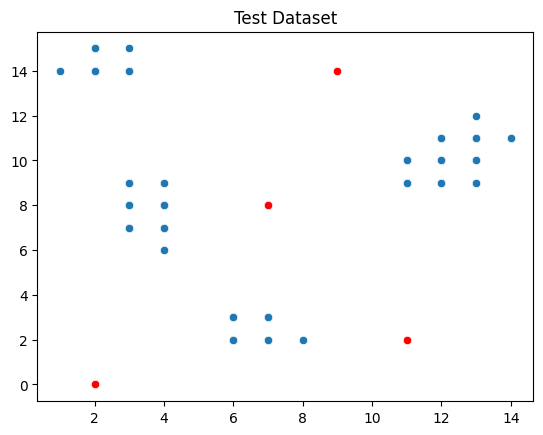

In [33]:
evaluate_qbm(qbm,testing_dataset,CLUSTER,plot=True,quantile=0.95,method='mean')

In [19]:
qbm.biases_visible

tensor([-0.07339898,  0.02473961,  0.06295207,  0.01730693,  0.10229073,
        -0.10764407,  0.09751166, -0.05976842], requires_grad=True)